# Импорт библиотек

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

# Импорт данных

In [2]:
orders = pd.read_csv('orders.csv')
visitation = pd.read_csv('visitation.csv')
expenses = pd.read_csv('expenses.csv')
print(orders.shape)
orders.head()

(40212, 3)


,User Id,Event Dt,Revenue
0,188246423999,2022-05-01 23:09:52,4.99
1,174361394180,2022-05-01 12:24:04,4.99
2,529610067795,2022-05-01 11:34:04,4.99
3,319939546352,2022-05-01 15:34:40,4.99
4,366000285810,2022-05-01 13:59:51,4.99


In [3]:
print(visitation.shape)
visitation.head()

(309901, 6)


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,Russia,iPhone,organic,2022-05-01 02:36:01,2022-05-01 02:45:01
1,278965908054,Russia,iPhone,organic,2022-05-01 04:46:31,2022-05-01 04:47:35
2,590706206550,Russia,Mac,organic,2022-05-01 14:09:25,2022-05-01 15:32:08
3,326433527971,Russia,Android,TipTop,2022-05-01 00:29:59,2022-05-01 00:54:25
4,349773784594,Russia,Mac,organic,2022-05-01 03:33:35,2022-05-01 03:57:40


In [4]:
print(expenses.shape)
expenses.head()

(1800, 3)


,dt,Channel,costs
0,2022-05-01,FaceBoom,113.3
1,2022-05-02,FaceBoom,78.1
2,2022-05-03,FaceBoom,85.8
3,2022-05-04,FaceBoom,136.4
4,2022-05-05,FaceBoom,122.1


# Загрузка файлов в базу данных

In [5]:
# подключаем базу данных
con = sqlite3.connect("db.db")
cur = con.cursor()

In [6]:
try:
    # Загрузка orders в базу
    orders.to_sql('orders', con,
              if_exists='replace', index=False)
    
    # Загрузка visitation в базу
    visitation.to_sql('visitation', con,
              if_exists='replace', index=False)
    
    # Загрузка expenses в базу
    expenses.to_sql('expenses', con,
              if_exists='replace', index=False)
except:
    print('Ошибка при загрузке данных!!!')
else:
    print('Успешно!')

Успешно!


## Излекаем необходимые данные из базы данные

In [7]:
try:
    # Загрузка orders в базу
    query = 'select * from orders'
    orders = pd.read_sql(query, con)
    
    # Загрузка visitation в базу
    query = 'select * from visitation'
    visitation = pd.read_sql(query, con)
    
    # Загрузка expenses в базу
    query = 'select * from expenses'
    expenses = pd.read_sql(query, con)
except:
    print('Ошибка при загрузке данных!!!')
else:
    print('Успешно!')

Успешно!


# 

# Предобработка данных

## Анализ пропусков

In [8]:
orders.isna().sum()

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [9]:
visitation.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [10]:
expenses.isna().sum()

dt         0
Channel    0
costs      0
dtype: int64

### Пропусков не обнаружено

## Анализ дубликатов

In [11]:
orders.duplicated().sum()

0

In [12]:
visitation.duplicated().sum()

0

In [13]:
expenses.duplicated().sum()

0

### Дубликатов не обнаружено

#

## Анализ выбросов (аномальных значений)

<Axes: >

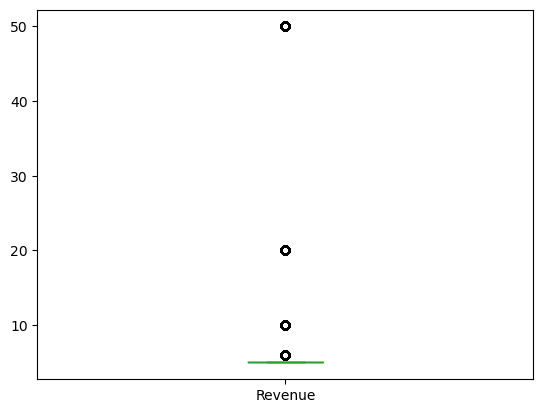

In [14]:
orders.drop('User Id',axis=1).plot(kind='box')

#### В наборе orders признак revenue имеет 4 выброса, удаляем их 

In [15]:
orders = orders[orders['Revenue'] < 5]

<Axes: >

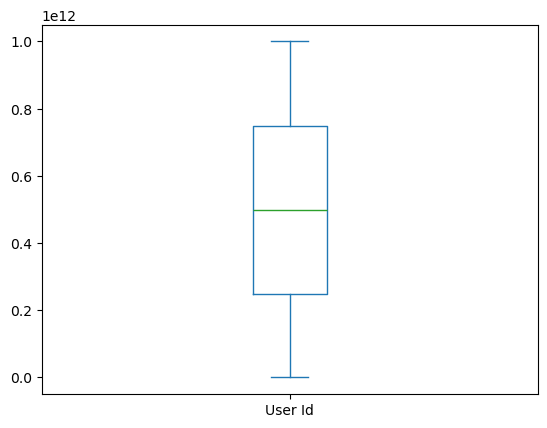

In [16]:
visitation.plot(kind='box')

#### В наборе visitation выбросов не обнаружено

<Axes: >

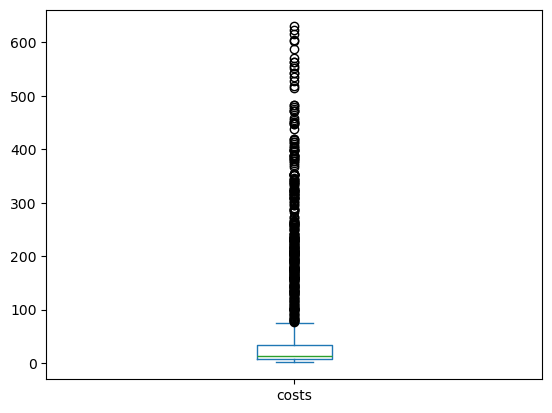

In [17]:
expenses.plot(kind='box')

#### В наборе expenses признак costs имеет много значений, превышающих 75 процентиль. Это обусловливаться разной затратой на привлечение, и мы не можем исключать эти важные данные из набора

## Сохраняем предобработанные данные и загружаем их в базу

In [18]:
# Сохраняем данные в формате csv
orders.to_csv('orders_new.csv', index=False)
visitation.to_csv('visitation_new.csv', index=False)
expenses.to_csv('expenses_new.csv', index=False)

In [19]:
try:
    # Загрузка orders в базу
    orders.to_sql('orders', con,
              if_exists='replace', index=False)
    
    # Загрузка visitation в базу
    visitation.to_sql('visitation', con,
              if_exists='replace', index=False)
    
    # Загрузка expenses в базу
    expenses.to_sql('expenses', con,
              if_exists='replace', index=False)
except:
    print('Ошибка при загрузке данных!!!')
else:
    print('Успешно!')
con.close()

Успешно!


#

# Задание функций для расчета ключевых показателей

### Функция для формирования профилей пользователя

In [20]:
def create_profile_df(orders, visitation, expenses):

    # Оставляем только первое посещене пользователя
    df = visitation[['User Id', 'Session Start', 'Session End', 'Device', 'Region', 'Channel']]
    df = df.sort_values(by=['Session Start']).drop_duplicates(keep='first', subset='User Id')
    
    # добавляем дату первого посещения
    df['Session Start'] = pd.to_datetime(df['Session Start'])
    df['Session End'] = pd.to_datetime(df['Session End'])
    df['date'] = df['Session Start'].dt.date
    
    # считаем среднюю стоимость привлечения пользователей в день
    mean_cost = expenses.groupby('dt', as_index=False).agg({'costs': ['mean']})[['dt', 'costs']]
    mean_cost.columns = mean_cost.columns.droplevel(0)
    mean_cost = mean_cost.rename(columns={'': 'date'})
    mean_cost['date'] = pd.to_datetime(mean_cost['date']).dt.date
    df = pd.merge(df, mean_cost,
         on='date', how='left')

    return df


df = create_profile_df(orders, visitation, expenses)
# Сохраняем профили в формате csv
df.to_csv('profiles.csv', index=False)
df.head()

,User Id,Session Start,Session End,Device,Region,Channel,date,mean
0,382394863972,2022-05-01 00:00:41,2022-05-01 01:13:45,Mac,Russia,MediaTornado,2022-05-01,30.482
1,428935481941,2022-05-01 00:01:35,2022-05-01 02:30:30,PC,Turkey,AdNonSense,2022-05-01,30.482
2,86266511938,2022-05-01 00:02:38,2022-05-01 01:22:33,Android,China,organic,2022-05-01,30.482
3,763000657462,2022-05-01 00:04:21,2022-05-01 00:24:15,PC,Turkey,organic,2022-05-01,30.482
4,791058813280,2022-05-01 00:05:17,2022-05-01 01:14:51,Android,Thailand,LeapBob,2022-05-01,30.482


### Функция для расчёта прибыли от клиентов (LTV) 





LTV (Lifetime Value) — это прогнозируемая сумма прибыли, которую компания может получить от клиента за весь период его взаимодействия с бизнесом. Рассчитывается как произведение среднего дохода от клиента за определённый период и средней продолжительности его жизни.

In [21]:
def get_ltv(df):
    # Средний доход одного пользователя
    arpu = df.groupby('User Id')['Revenue'].sum().mean()
    
    # Средняя продолжительность жизни клиента, мы считаем, что клиенты живут в среднем 24 месяца
    clv = 24 
    
    # Рассчитываем LTV
    ltv = arpu * clv
    print(f"Lifetime Value (LTV) = {ltv}")

get_ltv(orders)

Lifetime Value (LTV) = 528.8578600823046


### Функция для расчета коэффициента окупаемости вложений (ROI)

ROI (Return on Investment) измеряет эффективность инвестиций и показывает, сколько прибыли приносит каждый потраченный рубль.

In [22]:
def get_roi(df, investment):
    # Доход от пользователей (общая сумма, потраченная всеми пользователями)
    revenue = df.groupby('User Id')['Revenue'].sum().sum()
    
    # Рассчитываем ROI
    roi = (revenue - investment) / investment * 100
    print(f"Return on Investment (ROI) = {roi:.2f}%")

get_roi(orders, 100000)

Return on Investment (ROI) = 92.77%


Для вычисления коэффициента удержания и конверсии 

### Функции для расчёта удержания клиентов

Retention Rate (Уровень удержания) — это процент пользователей, которые вернулись в сервис за определённый период времени. Рассчитывается как отношение числа возвращённых пользователей к общему числу пользователей.

In [23]:
def get_retention(orders):
    # пользователи, которые вернулись
    returned = (orders.groupby(['User Id'])['Event Dt'].count() > 1).sum()
    # общее число пользователей
    all_users = orders['User Id'].nunique()

    print(f"Уровень удержания = {returned / all_users * 100:.2f}%") 
get_retention(orders)

Уровень удержания = 64.43%


### Функция для расчёта конверсии

Conversion Rate (Конверсия) — это процент пользователей, которые совершили целевое действие (например, покупку) по отношению к общему числу пользователей, посетивших сайт или приложение.

In [24]:
def get_conversion(orders, visitation):
    # пользователи, которых привлекли
    attracted = visitation['User Id'].nunique()
    # пользоатели, которые совершили покупку
    purchased = orders['User Id'].nunique()

    print(f"Конверсия = {(purchased / attracted) * 100:.2f}%") 
get_conversion(orders, visitation)

Конверсия = 5.83%


#

# Вывод

В ходе модуля А, были сделаны следующие действия:
* создана база данных
* проведена предобработка данных
* задана фунция для формирования набора данных профилей пользователя
* определены функции для расчета LTV, ROI, коэффициента удержания и конверсии